In [3]:
#!pip install torch-geometric


In [4]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
data = dataset[0]  # Only one graph


In [11]:
# node features
print(data.x)
#  ground-truth labels (for community classification)
print(data.y)
# graph connectivity
print(data.edge_index)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,

Visualize the Graph

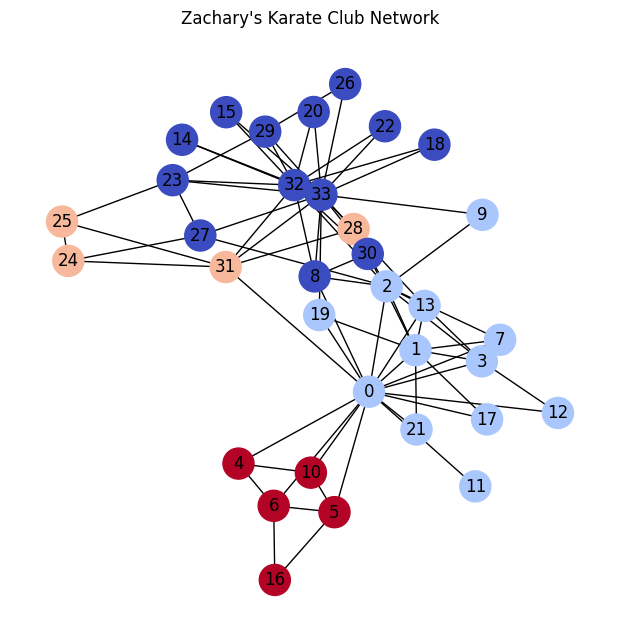

In [12]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_size=500, node_color=data.y, cmap='coolwarm')
plt.title("Zachary's Karate Club Network")
plt.show()


Build a GCN for Node Classification

In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class KarateGCN(nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


Train the Model

In [14]:
model = KarateGCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.NLLLoss()

# Use 4 training nodes only (semi-supervised learning)
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[0] = True  # One from each class
data.train_mask[33] = True
data.train_mask[1] = True
data.train_mask[32] = True

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 1.4211
Epoch 2, Loss: 1.3559
Epoch 3, Loss: 1.2936
Epoch 4, Loss: 1.2342
Epoch 5, Loss: 1.1774
Epoch 6, Loss: 1.1213
Epoch 7, Loss: 1.0663
Epoch 8, Loss: 1.0128
Epoch 9, Loss: 0.9598
Epoch 10, Loss: 0.9077
Epoch 11, Loss: 0.8563
Epoch 12, Loss: 0.8055
Epoch 13, Loss: 0.7549
Epoch 14, Loss: 0.7051
Epoch 15, Loss: 0.6563
Epoch 16, Loss: 0.6088
Epoch 17, Loss: 0.5630
Epoch 18, Loss: 0.5192
Epoch 19, Loss: 0.4775
Epoch 20, Loss: 0.4381
Epoch 21, Loss: 0.4008
Epoch 22, Loss: 0.3657
Epoch 23, Loss: 0.3330
Epoch 24, Loss: 0.3024
Epoch 25, Loss: 0.2740
Epoch 26, Loss: 0.2480
Epoch 27, Loss: 0.2241
Epoch 28, Loss: 0.2022
Epoch 29, Loss: 0.1820
Epoch 30, Loss: 0.1637
Epoch 31, Loss: 0.1471
Epoch 32, Loss: 0.1320
Epoch 33, Loss: 0.1185
Epoch 34, Loss: 0.1063
Epoch 35, Loss: 0.0955
Epoch 36, Loss: 0.0858
Epoch 37, Loss: 0.0771
Epoch 38, Loss: 0.0695
Epoch 39, Loss: 0.0626
Epoch 40, Loss: 0.0566
Epoch 41, Loss: 0.0512
Epoch 42, Loss: 0.0464
Epoch 43, Loss: 0.0421
Epoch 44, Loss: 0.03

Evaluate

In [15]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred == data.y).sum().item()
acc = correct / data.num_nodes
print(f"Accuracy: {acc:.2f}")


Accuracy: 0.71


Visualize Predictions

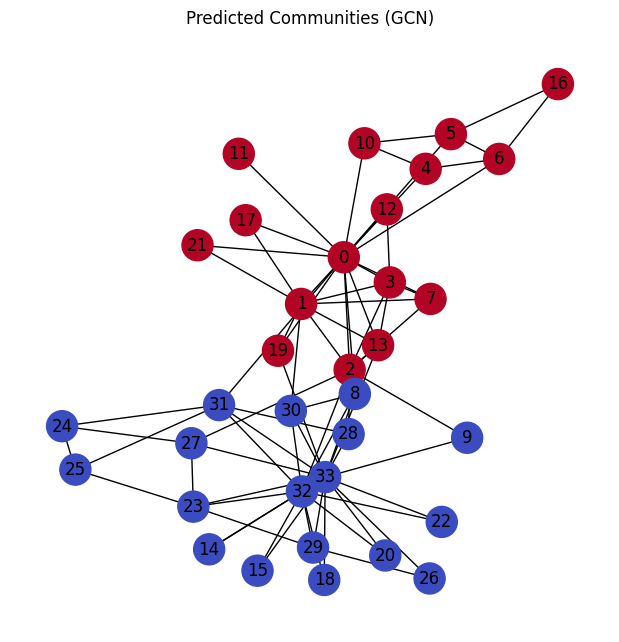

In [16]:
plt.figure(figsize=(6, 6))
nx.draw(G, node_color=pred, cmap='coolwarm', with_labels=True, node_size=500)
plt.title("Predicted Communities (GCN)")
plt.show()
